In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

keyword = "NormalNewGeom"
path = "../../../json/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

#omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = params["bumpData"]

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

# fcen = params["freqCenter"]
# df = params["freqWidth"]
# nfrq = params["freqs_n"]

lambda_min = params["minLambda"]
lambda_max = params["maxLambda"]
lambda_n = params["lambda_n"]


fcen = (1.0/lambda_max + 1.0/lambda_min)/2.0
df = 1.0 / lambda_min - 1.0 / lambda_max
nfrq = lambda_n


pml_layers = [mp.PML(thickness=pml_thickness)] 

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size[0], cell_size[1], 0),
        component=component
    )]


def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box1_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box1_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    sim.run(until_after_sources=60)

    box_x1 = mp.get_fluxes(box1_x1)
    box_x2 = mp.get_fluxes(box1_x2)
    box_y1 = mp.get_fluxes(box1_y1)
    box_y2 = mp.get_fluxes(box1_y2)
    box_z1 = mp.get_fluxes(box1_z1)
    box_z2 = mp.get_fluxes(box1_z2)

    # Save individual components for later printing/plotting
    inc_flux_components = {
        "X1": np.asarray(box_x1),
        "X2": np.asarray(box_x2),
        "Y1": np.asarray(box_y1),
        "Y2": np.asarray(box_y2),
        "Z1": np.asarray(box_z1),
        "Z2": np.asarray(box_z2),
    }

    box_x1_data = sim.get_flux_data(box1_x1)
    box_x2_data = sim.get_flux_data(box1_x2)
    box_y1_data = sim.get_flux_data(box1_y1)
    box_y2_data = sim.get_flux_data(box1_y2)
    box_z1_data = sim.get_flux_data(box1_z1)
    box_z2_data = sim.get_flux_data(box1_z2)

    sim.reset_meep()

# Structured simulation (with bumps) and edges
    def material_function(p):
        if abs(p.x) >= 1 or abs(p.y) >= 1:
            return mp.air
        z_surface = 0
        for b in bumps:
            dx = p.x - b["x0"]
            dy = p.y - b["y0"]
            exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
            z_surface += b["height"] * math.exp(exponent)
        return substrate if p.z + 1.5 < z_surface else mp.air



    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box2_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box2_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.load_minus_flux_data(box2_x1, box_x1_data)
    sim.load_minus_flux_data(box2_x2, box_x2_data)
    sim.load_minus_flux_data(box2_y1, box_y1_data)
    sim.load_minus_flux_data(box2_y2, box_y2_data)
    sim.load_minus_flux_data(box2_z1, box_z1_data)
    sim.load_minus_flux_data(box2_z2, box_z2_data)

    sim.run(until_after_sources=60) # maybe 20 is too little? 

    box_x1_flux = mp.get_fluxes(box2_x1)
    box_x2_flux = mp.get_fluxes(box2_x2)
    box_y1_flux = mp.get_fluxes(box2_y1)
    box_y2_flux = mp.get_fluxes(box2_y2)
    box_z1_flux = mp.get_fluxes(box2_z1)
    box_z2_flux = mp.get_fluxes(box2_z2)

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux),
        "X2": np.asarray(box_x2_flux),
        "Y1": np.asarray(box_y1_flux),
        "Y2": np.asarray(box_y2_flux),
        "Z1": np.asarray(box_z1_flux),
        "Z2": np.asarray(box_z2_flux),
    }


    freqs = mp.get_flux_freqs(box1_x1)  # or any box that was added with add_flux
    return scatt_flux_components, inc_flux_components, freqs


flux_results = []
inc_flux_results = []

def print_parameters():
    print("Simulation Parameters:")
    print(f"  resolution      = {resolution}")
    print(f"  cell_size       = ({cell_size.x}, {cell_size.y}, {cell_size.z})")
    print(f"  PML thickness   = {pml_thickness}")
    print(f"  monitor size    = {monitor_size}")
    print(f"  substrate ε     = {epsilon1}")
    print(f"  number of bumps = {len(bumps)}")
    print(f"  freq center     = {fcen:.4f} (→ λ ≈ {100 / fcen:.1f} nm)")
    print(f"  freq width      = {df:.4f} (from {fcen - df/2:.4f} to {fcen + df/2:.4f})")
    print(f"  freqs_n         = {nfrq} points")
    print("  betas (deg)     =", [round(np.degrees(b), 2) for b in betas])
    print()
print_parameters()


for beta in betas:
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_1 = make_source(mp.Ey)
    sources_2 = make_source(mp.Ex)
    
    flux_1, inc_flux_1, freqs = run_meep_simulation(sources_1)
    flux_2, inc_flux_2, freqs = run_meep_simulation(sources_2)

    for direction in ["X1", "X2", "Y1", "Y2", "Z1", "Z2"]:
        flux_arr = cos2 * flux_1[direction] + sin2 * flux_2[direction]
        inc_flux_arr = cos2 * inc_flux_1[direction] + sin2 * inc_flux_2[direction]

        for f, scatt_val, inc_val in zip(freqs, flux_arr, inc_flux_arr):
            flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": scatt_val,
                "type": "scattered"
            })
            inc_flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": inc_val,
                "type": "incident"
            })




FileNotFoundError: [Errno 2] No such file or directory: '../../../json/surfaceParamsNormaNewGeom.json'

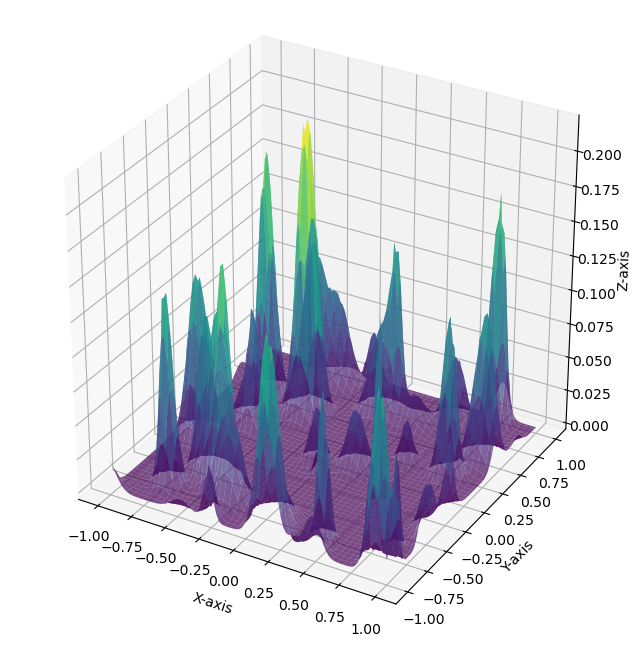

In [ ]:
#Plot the bump surface as in the material function
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

bumps = params["bumpData"]

def plot_bump_surface():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1

    # Create a grid of points
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the Z values based on the bumps
    Z = np.zeros_like(X)
    for b in bumps:
        dx = X - b["x0"]
        dy = Y - b["y0"]
        exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
        Z += b["height"] * np.exp(exponent)

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()
plot_bump_surface()


In [ ]:
import pandas as pd

df_scatt = pd.DataFrame(flux_results)
df_inc = pd.DataFrame(inc_flux_results)

# Save both to CSV
df_scatt.to_csv("../filesCSV/scattered_flux_results.csv", index=False)
df_inc.to_csv("../filesCSV/incident_flux_results.csv", index=False)

# Confirm structure
print(df_scatt.head())


   frequency  beta direction          flux       type
0   1.388889   0.0        X1  8.265605e-07  scattered
1   1.666667   0.0        X1  5.764415e-06  scattered
2   1.944444   0.0        X1  6.083890e-06  scattered
3   2.222222   0.0        X1 -5.963531e-06  scattered
4   2.500000   0.0        X1  1.120610e-05  scattered


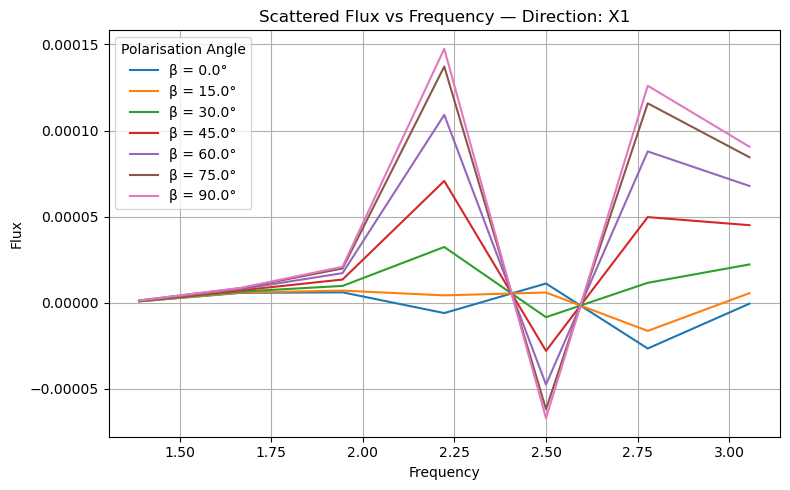

<Figure size 640x480 with 0 Axes>

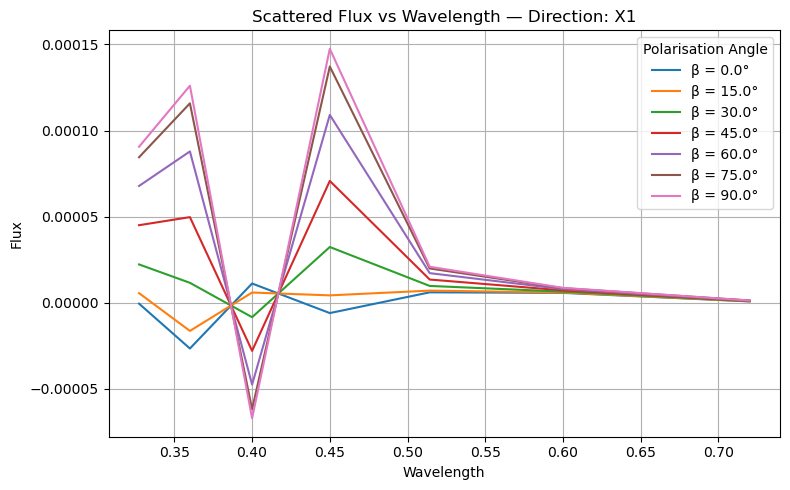

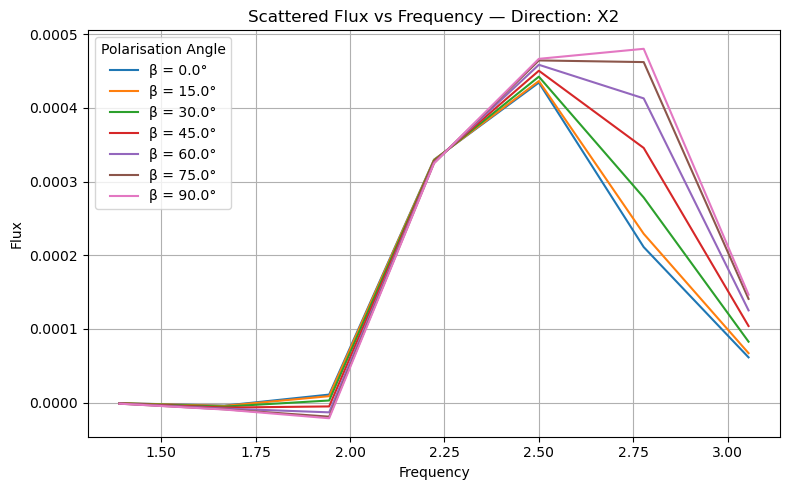

<Figure size 640x480 with 0 Axes>

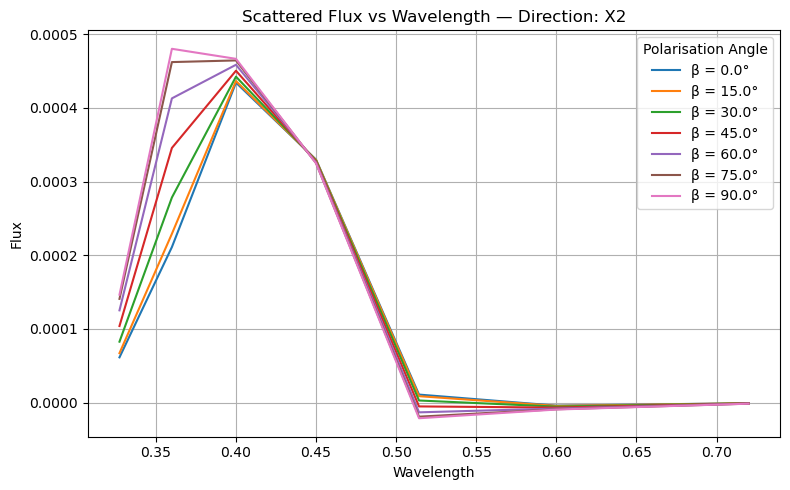

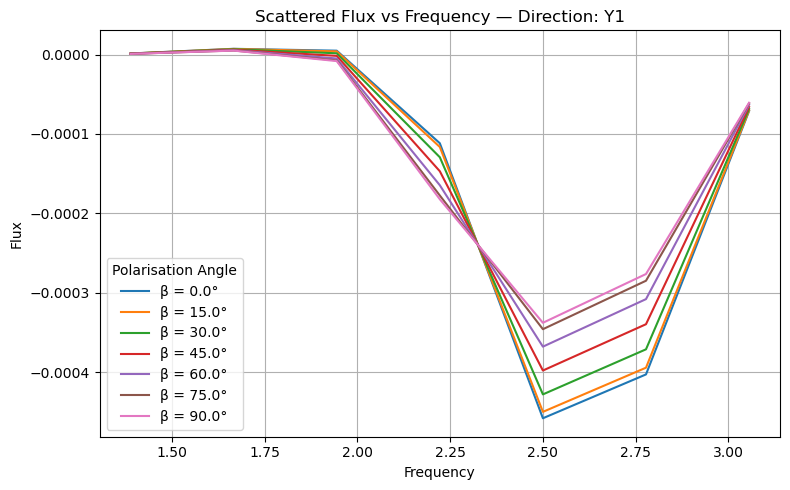

<Figure size 640x480 with 0 Axes>

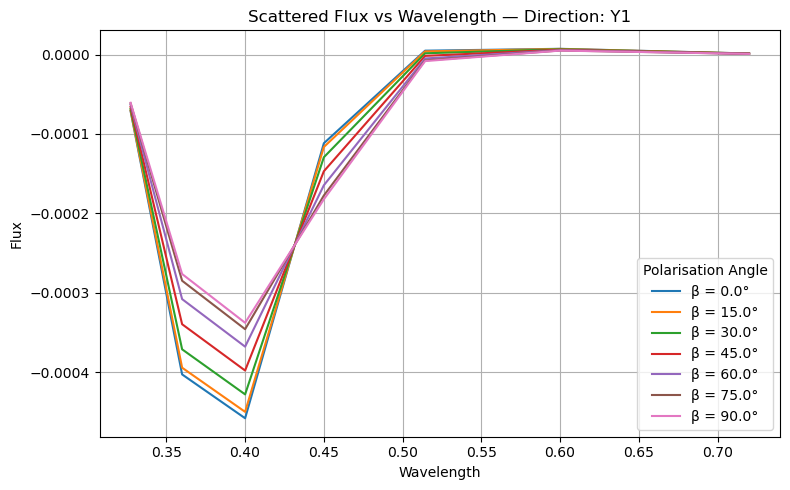

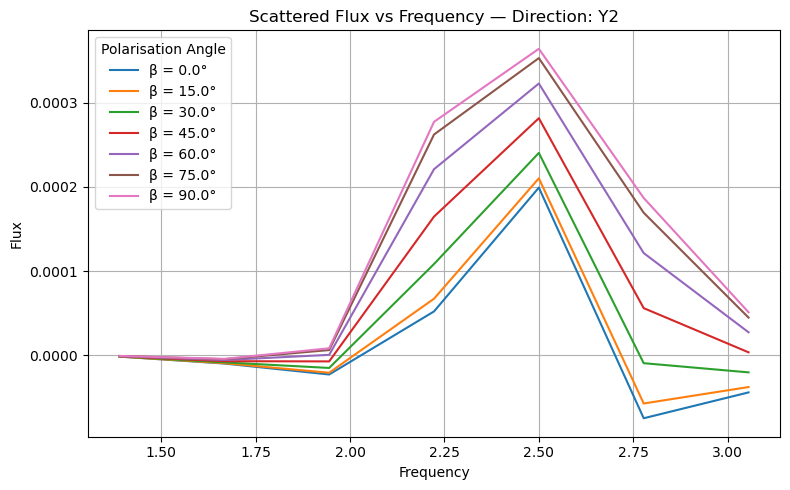

<Figure size 640x480 with 0 Axes>

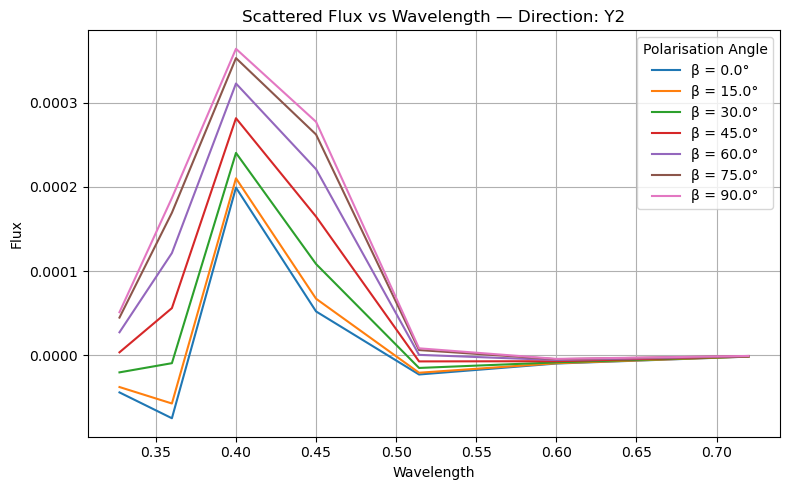

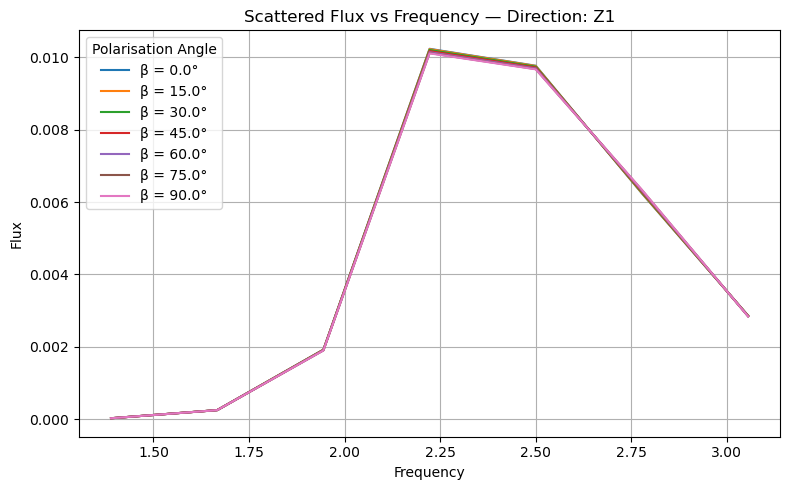

<Figure size 640x480 with 0 Axes>

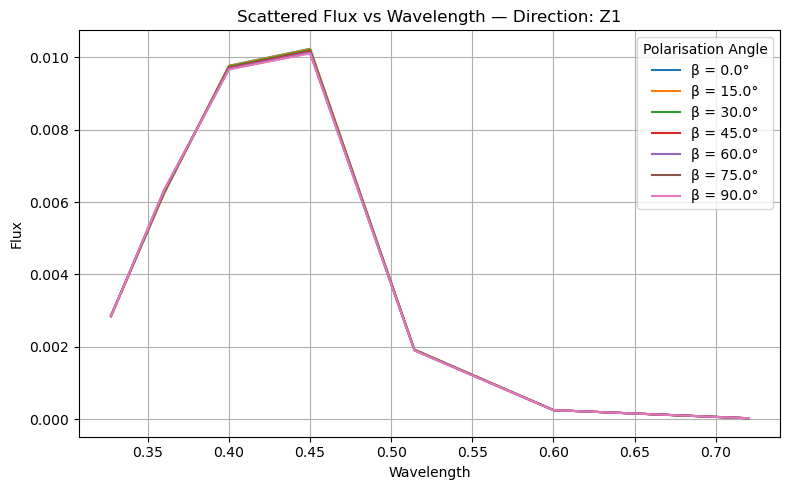

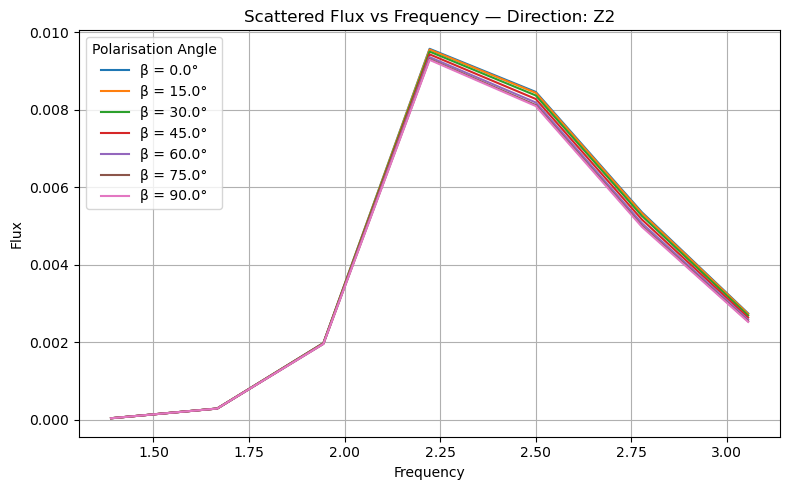

<Figure size 640x480 with 0 Axes>

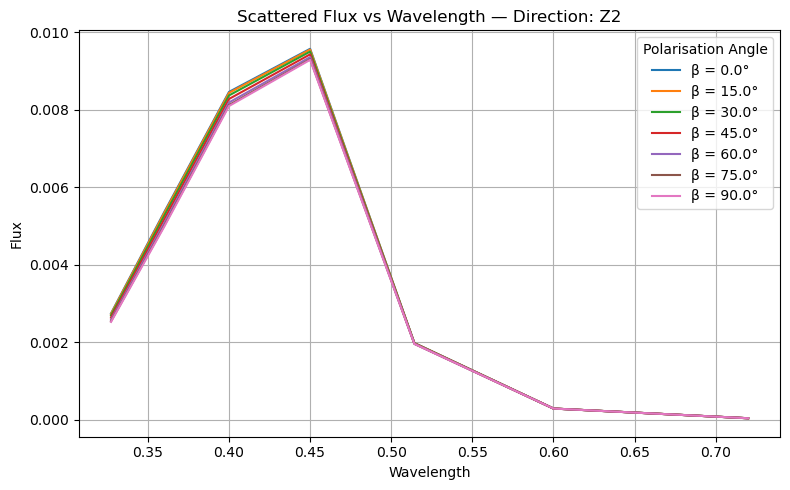

In [ ]:
import matplotlib.pyplot as plt

directions = sorted(df_scatt["direction"].unique())
betas = sorted(df_scatt["beta"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for beta in betas:
        sub = df_scatt[(df_scatt["direction"] == direction) & (df_scatt["beta"] == beta)]
        plt.plot(sub["frequency"], sub["flux"], label=f"β = {beta:.1f}°")

    plt.title(f"Scattered Flux vs Frequency — Direction: {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Polarisation Angle")
    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig(f"../plots/scattered_flux_{direction}.png")

    # Plot flux vs wavelength
    plt.figure(figsize=(8, 5))
    for beta in betas:
        sub = df_scatt[(df_scatt["direction"] == direction) & (df_scatt["beta"] == beta)]
        wavelengths = 1 / sub["frequency"]
        plt.plot(wavelengths, sub["flux"], label=f"β = {beta:.1f}°")
    plt.title(f"Scattered Flux vs Wavelength — Direction: {direction}")
    plt.xlabel("Wavelength")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Polarisation Angle")
    plt.tight_layout()
    plt.savefig(f"../plots/scattered_flux_wavelength_{direction}.png")
    plt.show()
    plt.close()
    


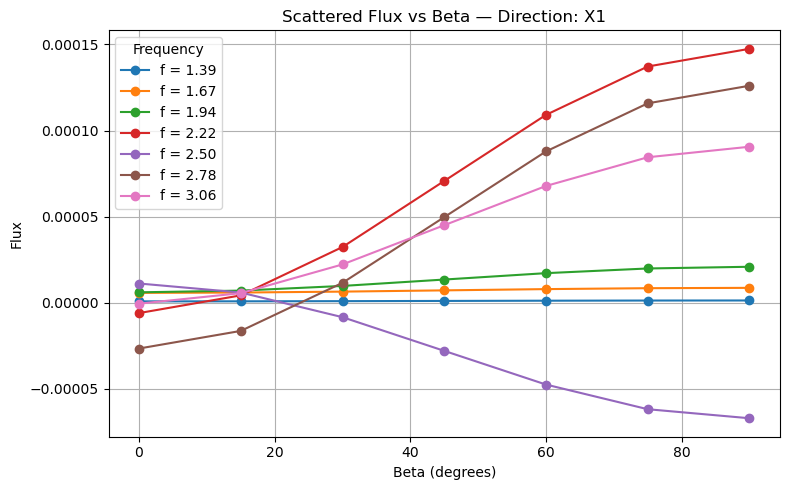

<Figure size 640x480 with 0 Axes>

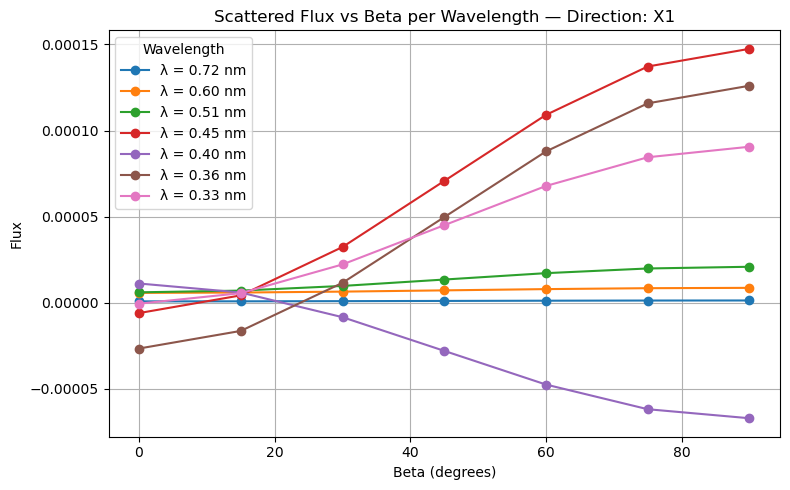

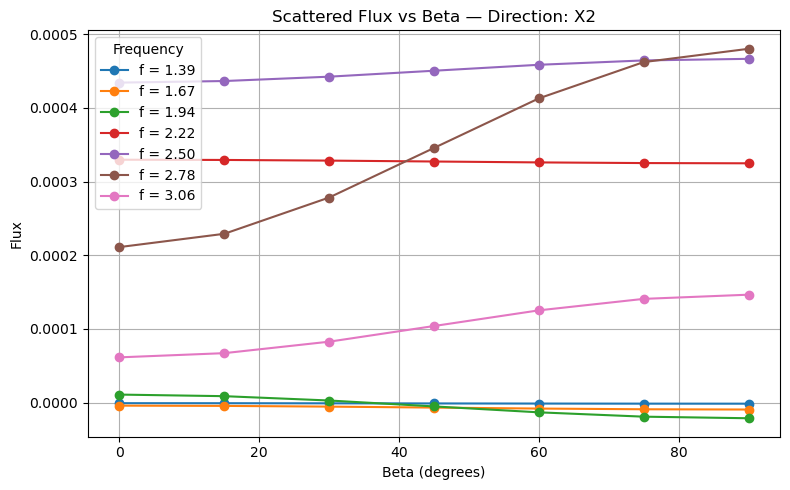

<Figure size 640x480 with 0 Axes>

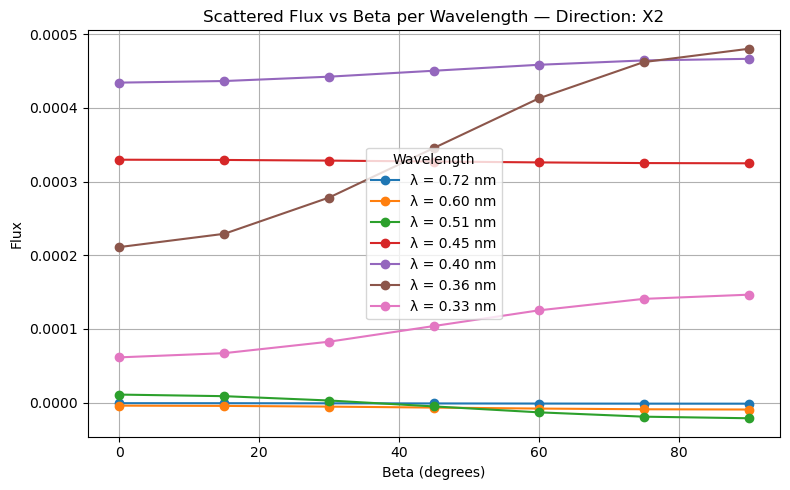

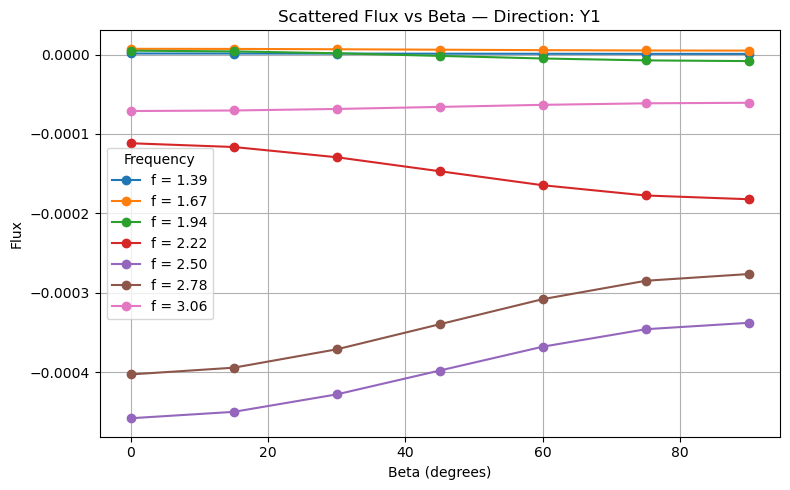

<Figure size 640x480 with 0 Axes>

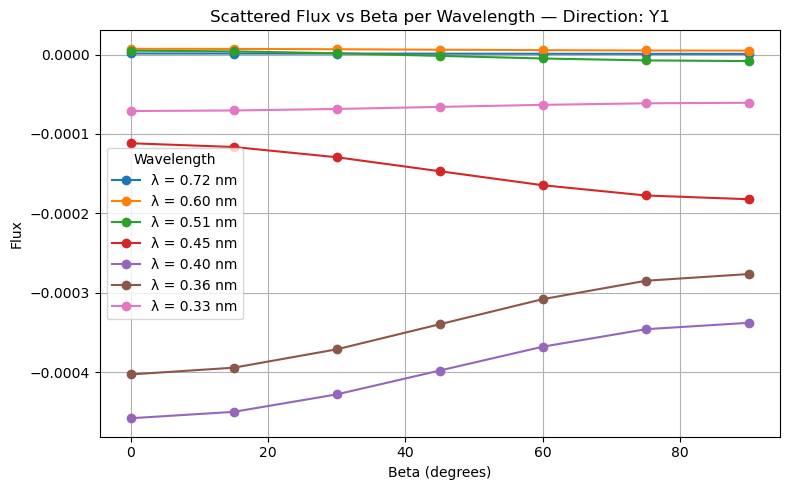

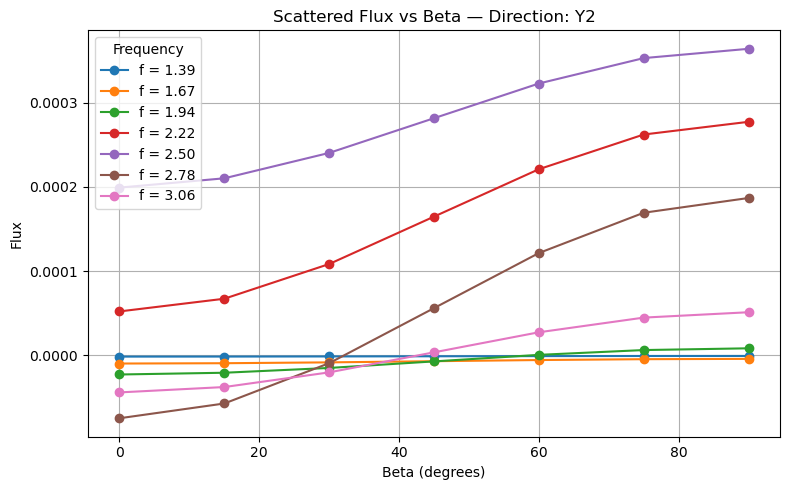

<Figure size 640x480 with 0 Axes>

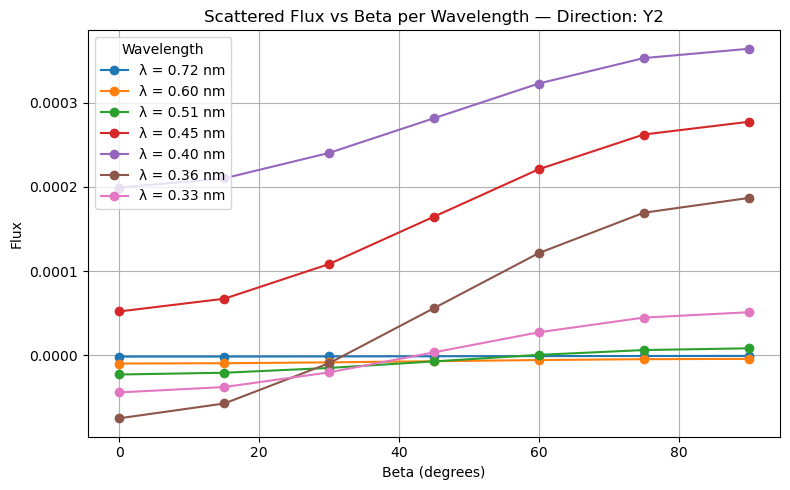

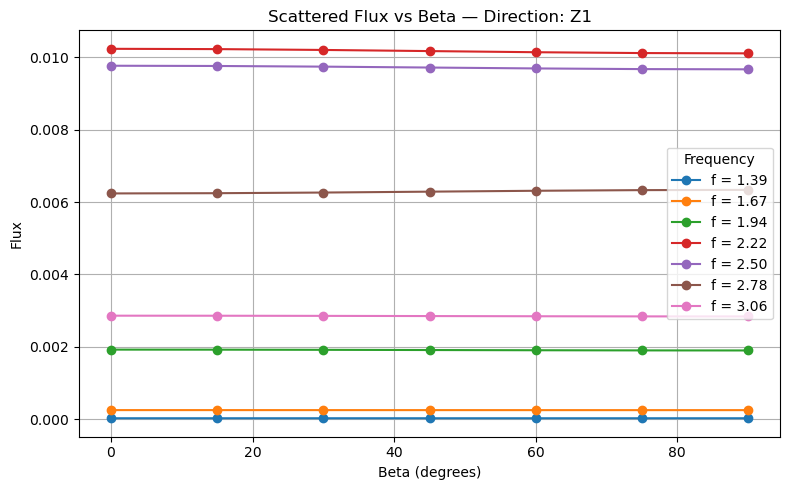

<Figure size 640x480 with 0 Axes>

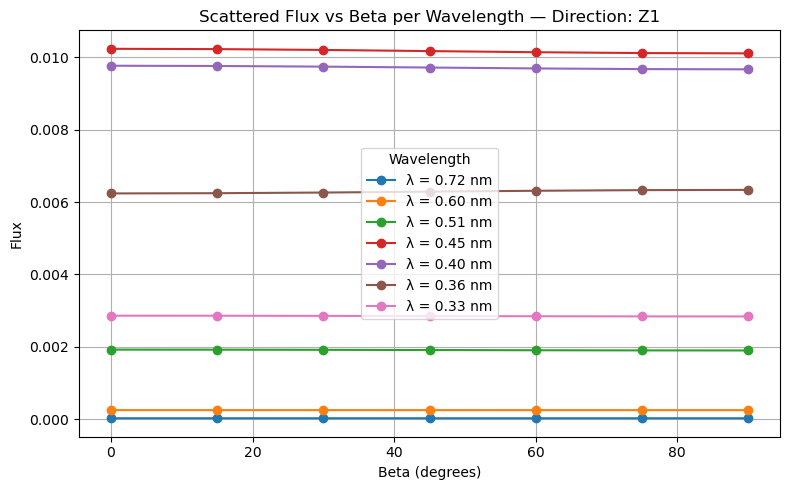

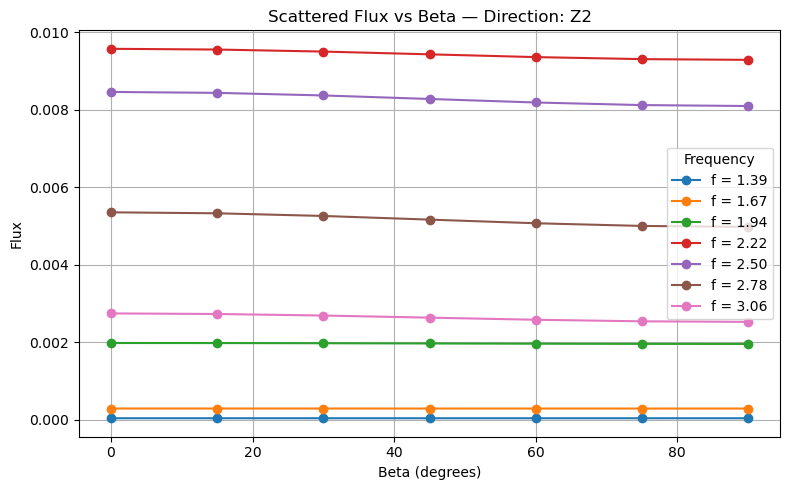

<Figure size 640x480 with 0 Axes>

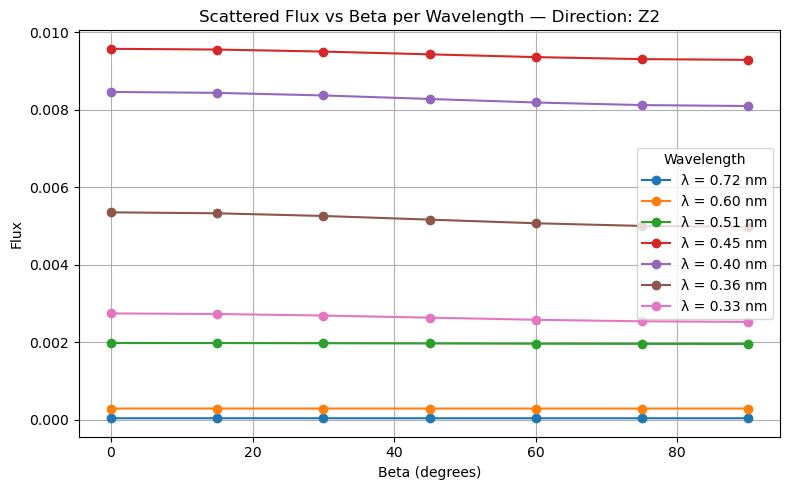

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

directions = sorted(df_scatt["direction"].unique())
frequencies = sorted(df_scatt["frequency"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for f in frequencies:
        sub = df_scatt[(df_scatt["direction"] == direction) & (np.isclose(df_scatt["frequency"], f, atol=1e-5))]
        plt.plot(sub["beta"], sub["flux"], marker='o', label=f"f = {f:.2f}")

    plt.title(f"Scattered Flux vs Beta — Direction: {direction}")
    plt.xlabel("Beta (degrees)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Frequency")
    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig(f"../plots/scattered_flux_beta_{direction}.png")

    # Plot flux vs beta per wavelength
    plt.figure(figsize=(8, 5))
    for f in frequencies:
        sub = df_scatt[(df_scatt["direction"] == direction) & (np.isclose(df_scatt["frequency"], f, atol=1e-5))]
        wavelengths = 1 / sub["frequency"]
        plt.plot(sub["beta"], sub["flux"], marker='o', label=f"λ = {wavelengths.iloc[0]:.2f} nm")
    plt.title(f"Scattered Flux vs Beta per Wavelength — Direction: {direction}")
    plt.xlabel("Beta (degrees)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Wavelength")
    plt.tight_layout()
    plt.savefig(f"../plots/scattered_flux_beta_wavelength_{direction}.png")
    plt.show()
    plt.close()



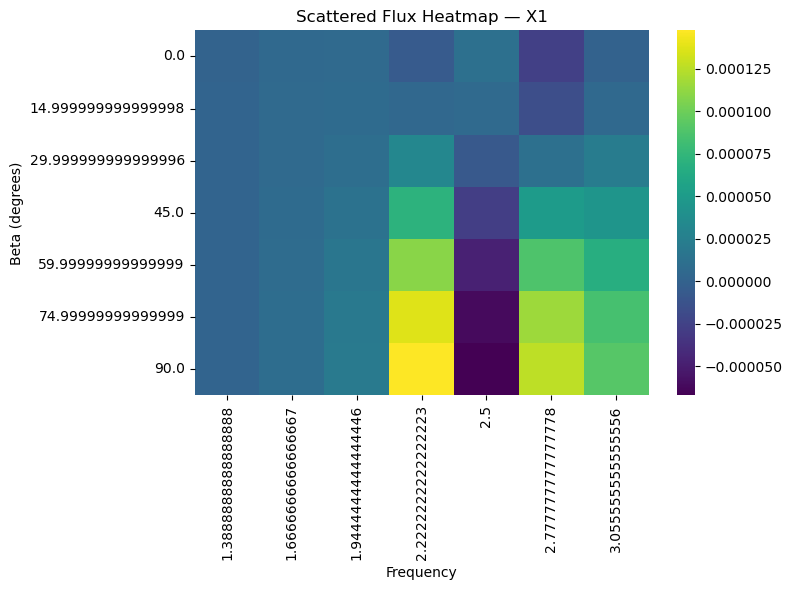

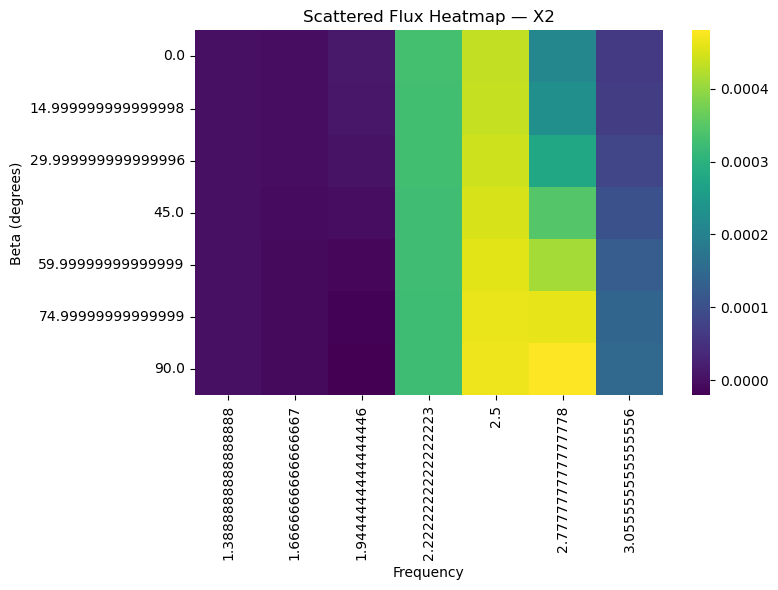

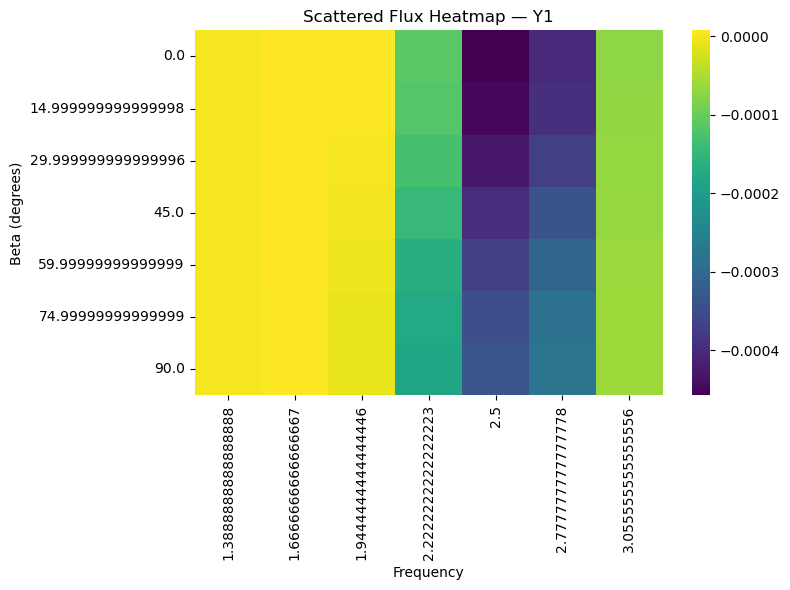

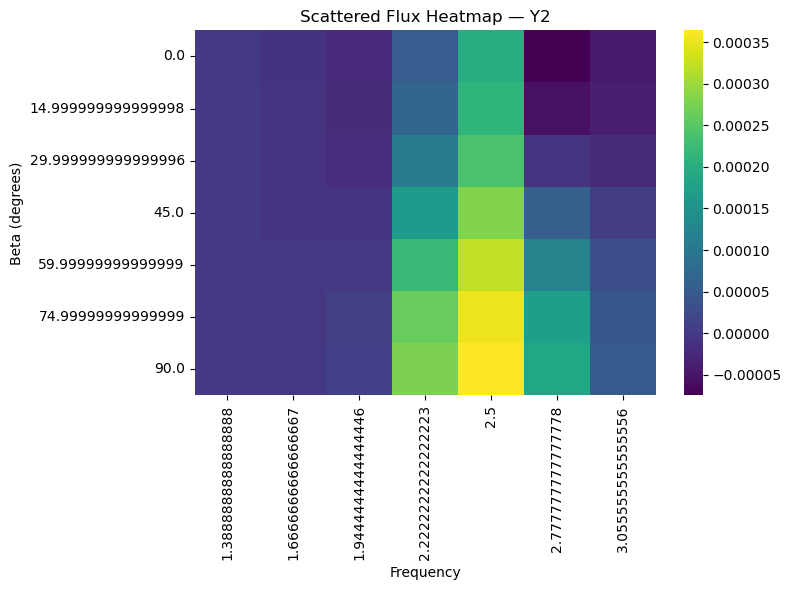

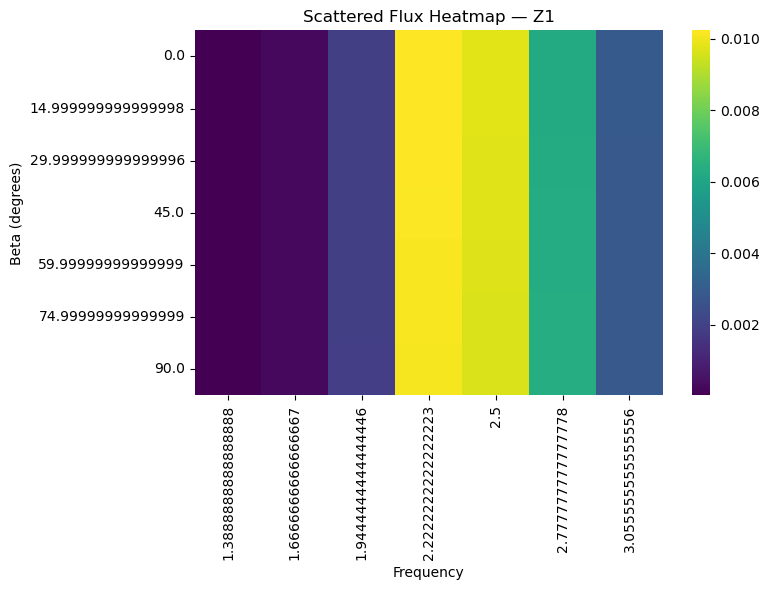

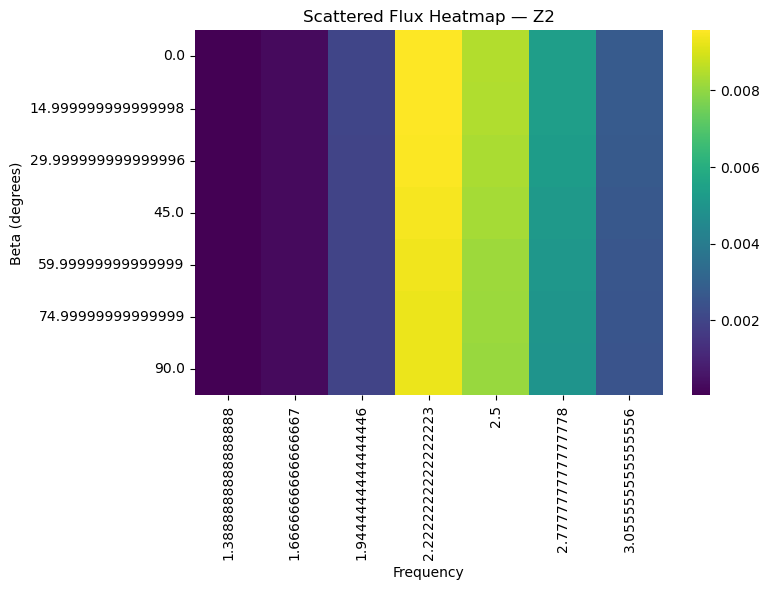

In [ ]:
import seaborn as sns
for direction in directions:
    df_pivot = df_scatt[df_scatt["direction"] == direction].pivot(index="beta", columns="frequency", values="flux")
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_pivot, cmap="viridis")
    plt.title(f"Scattered Flux Heatmap — {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Beta (degrees)")
    plt.tight_layout()
    plt.show()


In [ ]:
d = flux_1
#d = flux_1
print("Size of dict:", len(d))
d

Size of dict: 6


{'X1': array([ 8.26560467e-07,  5.76441464e-06,  6.08388967e-06, -5.96353138e-06,
         1.12061003e-05, -2.65396972e-05, -4.96975125e-07]),
 'X2': array([-7.99809899e-07, -4.12658049e-06,  1.08730273e-05,  3.29683945e-04,
         4.34313876e-04,  2.11098164e-04,  6.14151142e-05]),
 'Y1': array([ 1.32379280e-06,  7.23035409e-06,  4.87735059e-06, -1.11654086e-04,
        -4.57860095e-04, -4.02690370e-04, -7.11127959e-05]),
 'Y2': array([-1.46178675e-06, -9.68704846e-06, -2.27058662e-05,  5.21780084e-05,
         1.99209848e-04, -7.46576874e-05, -4.39780638e-05]),
 'Z1': array([2.79574097e-05, 2.52846255e-04, 1.92365611e-03, 1.02326173e-02,
        9.76492601e-03, 6.23780588e-03, 2.86089008e-03]),
 'Z2': array([3.33001955e-05, 2.84352881e-04, 1.97546342e-03, 9.57049536e-03,
        8.45746066e-03, 5.34928410e-03, 2.73931944e-03])}

In [ ]:
d = inc_flux_1
print("Size of dict:", len(d))
d




Size of dict: 6


{'X1': array([ 9.19504004e-21, -8.17785101e-20,  5.81992742e-20,  9.42051095e-20,
        -7.54926386e-20,  2.91943323e-21,  4.60908899e-20]),
 'X2': array([2.18700993e-20, 4.21444381e-20, 1.39200579e-19, 8.78135493e-20,
        1.39841436e-19, 2.63318017e-20, 2.66717016e-20]),
 'Y1': array([ 2.13293946e-20,  2.64236908e-20,  8.42077768e-20, -8.63675328e-20,
         7.65125064e-20, -2.02815165e-19,  1.90195334e-19]),
 'Y2': array([-2.69668928e-20,  6.18607713e-20,  4.39507883e-20,  1.58951622e-19,
        -2.79602142e-19,  1.15621222e-19, -2.68670886e-19]),
 'Z1': array([-0.00020564, -0.00120182, -0.00397615, -0.00742403, -0.00792385,
        -0.00515531, -0.00216199]),
 'Z2': array([-0.00020287, -0.00120493, -0.00397693, -0.00741552, -0.0079596 ,
        -0.0051654 , -0.00217388])}